# 4_metrics_nucleus_celltype_diversity

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from thalamus_merfish_analysis import ccf_plots as cplot
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_registration as ccf
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_erode as cerd
from thalamus_merfish_analysis import diversity_metrics as divmet
from thalamus_merfish_analysis import diversity_plots as dplot

get_ipython().run_line_magic('matplotlib', 'inline') 

## Load ABC Thalamus dataset

In [3]:
# load just the obs
obs = abc.load_standard_thalamus(data_structure='obs')

In [4]:
# load CCF image volumes
realigned=False
ccf_images = abc.get_ccf_labels_image(resampled=True, realigned=realigned)

In [5]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'
x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

## Define eroded CCF regions

In [6]:
obs_erode = cerd.label_cells_by_eroded_ccf(obs, ccf_images) # default is erosion by 5px (5um)

In [7]:
# There is poor alignment in section 6.6 between PF celltypes and the PF CCF structure
# So, we'll set all cells in section 6.6 to 'unassigned' CCF structure
obs_erode.loc[lambda df: df['z_section']==6.6, cerd.ERODED_CCF_STRUCTURE_COL] = 'unassigned'

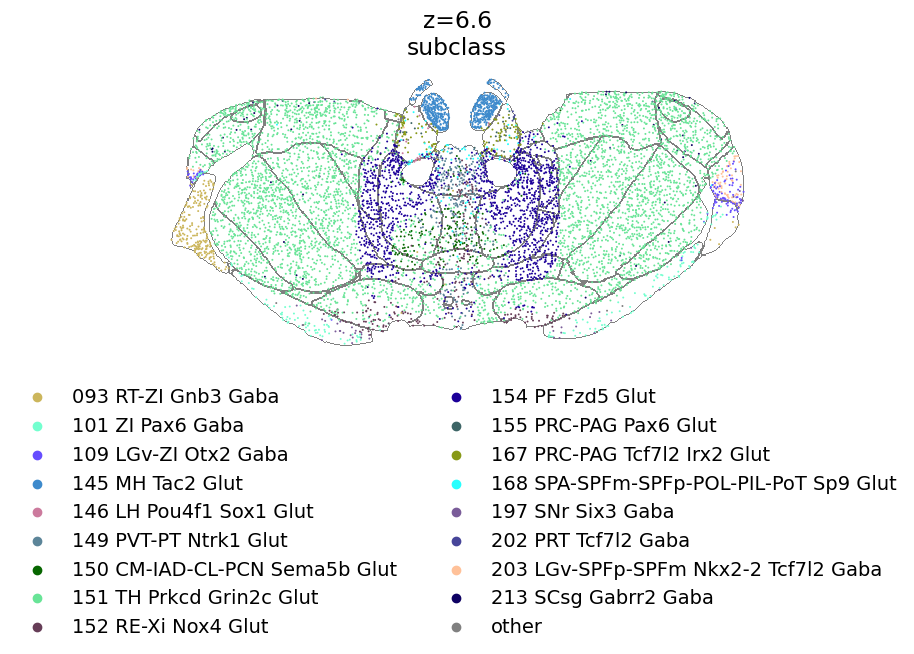

In [8]:
# We can visualize this mismatch (see `154 PF Fzd5 Glut` subclass in dark blue) 
# by using our plotting functions from the `2_view_thalamus_celltypes_ccf` notebook
taxonomy_level = ['subclass']#, 'supertype']
for level in taxonomy_level:
    sec66_fig = cplot.plot_ccf_overlay(obs_erode, ccf_images, 
                                        point_hue=level, 
                                        sections=[6.6],
                                        point_palette=abc.get_taxonomy_palette(level),
                                        legend='cells',
                                        section_col=section_col,
                                        x_col=x_col, 
                                        y_col=y_col,)

## Calculate default set of metrics

In [9]:
ccf_label='parcellation_structure_eroded'
th_ccf_metrics = divmet.calculate_diversity_metrics(obs_erode, ccf_label=ccf_label)
display(th_ccf_metrics.head(5))

,count_cluster,count_supertype,count_subclass,frac_cluster,frac_supertype,frac_subclass,count_norm2cells_cluster,count_norm2cells_supertype,count_norm2cells_subclass,count_gt5_cluster,...,frac_gt5_cluster,frac_gt5_supertype,frac_gt5_subclass,inverse_simpsons_cluster,inverse_simpsons_supertype,inverse_simpsons_subclass,shannon_index_cluster,shannon_index_supertype,shannon_index_subclass,count_cells
parcellation_structure_eroded,,,,,,,,,,,,,,,,,,,,,
AD,4,3,3,0.007105,0.018405,0.051724,0.005988,0.004491,0.004491,2,...,0.003552,0.006135,0.017241,1.632833,1.009031,1.009031,0.864324,0.045613,0.045613,668
AM,32,18,8,0.056838,0.110429,0.137931,0.047478,0.026706,0.011869,7,...,0.012433,0.042945,0.051724,4.577734,1.610954,1.185462,2.772185,1.396615,0.560040,674
AV,17,8,3,0.030195,0.049080,0.051724,0.016618,0.007820,0.002933,7,...,0.012433,0.030675,0.034483,2.503736,1.276695,1.261530,1.738747,0.757764,0.529712,1023
CL,37,17,5,0.065719,0.104294,0.086207,0.087678,0.040284,0.011848,14,...,0.024867,0.049080,0.051724,9.256887,5.245479,1.795636,3.906723,2.831493,1.175209,422
CM,33,18,4,0.058615,0.110429,0.068966,0.070968,0.038710,0.008602,21,...,0.037300,0.073620,0.051724,12.364900,6.931844,1.817551,4.179821,3.252881,1.154755,465


## Plot default metrics

### Select regions to plot

In [10]:
regions_to_plot = dplot.TH_DIVERSITY_REGIONS

### Plot cluster count & frac on dual y-axis barplot

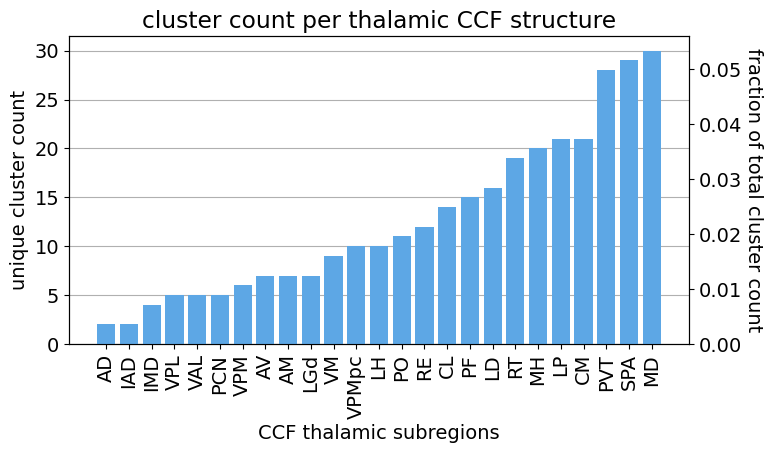

In [11]:
fig = dplot.barplot_dual_y_count_frac(th_ccf_metrics.loc[regions_to_plot], 'cluster', 
                                gt5_only=True)
# fig.savefig("/results/nuclei_cluster_counts_barplot.pdf", transparent=True)

### Plot unique cell type count

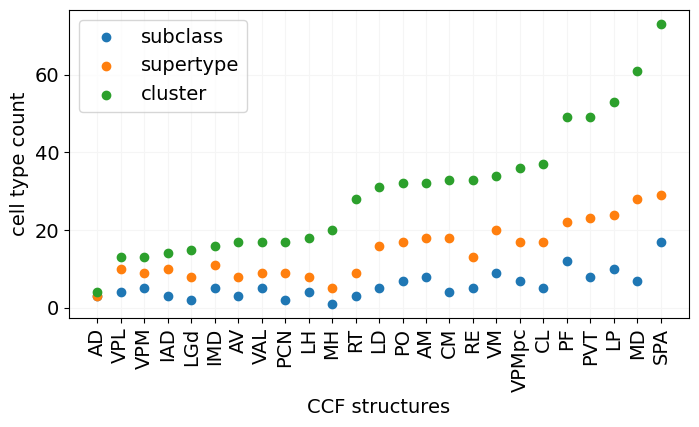

In [12]:
fig = dplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'count',
                                          ylabel="cell type count")

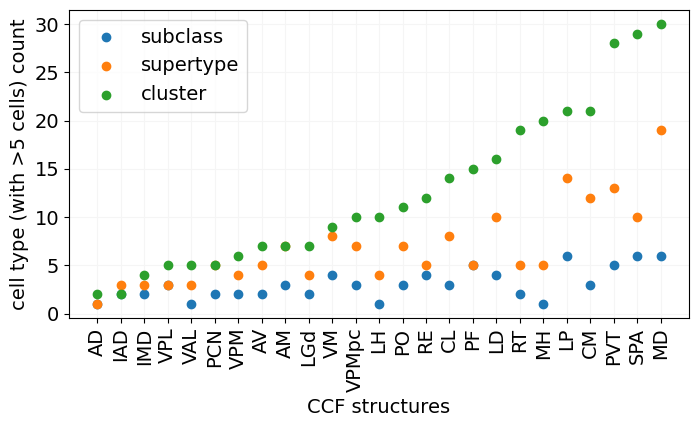

In [13]:
fig = dplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'count_gt5',
                                          ylabel='cell type (with >5 cells) count')

### Plot: cell type count / # cell types

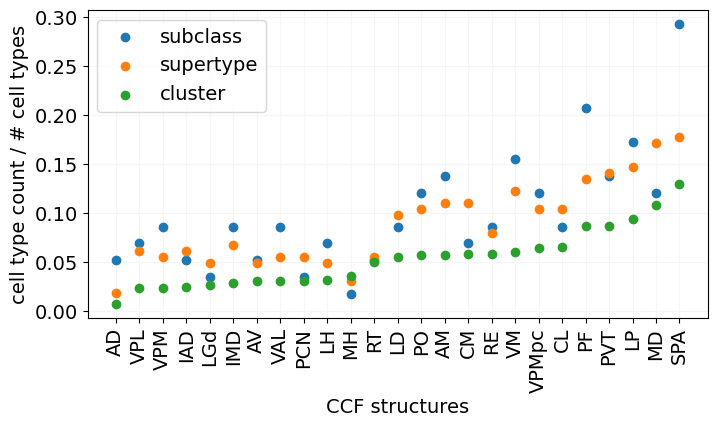

In [14]:
fig = dplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'frac',
                                          ylabel='cell type count / # cell types')

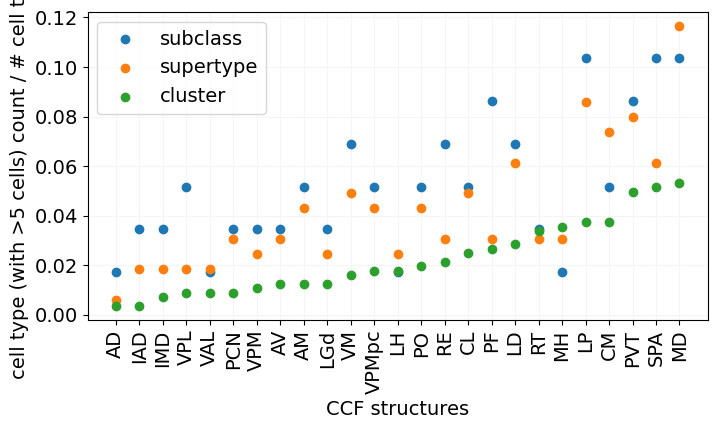

In [15]:
fig = dplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'frac_gt5',
                                          ylabel='cell type (with >5 cells) count / # cell types')

### Plot cell type counts, normalized to # of cells in each CCF region

This controls for differing cell densities & region sizes across CCF structures

There is a wide range of sizes (here, we mean # of cells) & cell densities across thalamic CCF structures:

In [16]:
print('thalamic structure with fewest cells:\n', 
      th_ccf_metrics.loc[regions_to_plot]['count_cells'].idxmin(), 
      th_ccf_metrics.loc[regions_to_plot]['count_cells'].min())
print('thalamic structure with most cells:\n', 
      th_ccf_metrics.loc[regions_to_plot]['count_cells'].idxmax(), 
      th_ccf_metrics.loc[regions_to_plot]['count_cells'].max())


thalamic structure with fewest cells:
 IAD 128
thalamic structure with most cells:
 VPM 3801


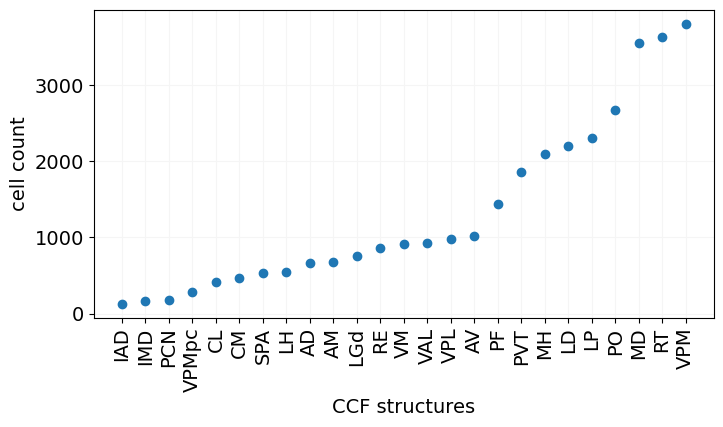

In [18]:
fig = dplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                        'count_cells', 
                                        taxonomy_levels=None,
                                        ylabel='cell count')

The effect of CCf structure size is weak, but present, and should be accounted for

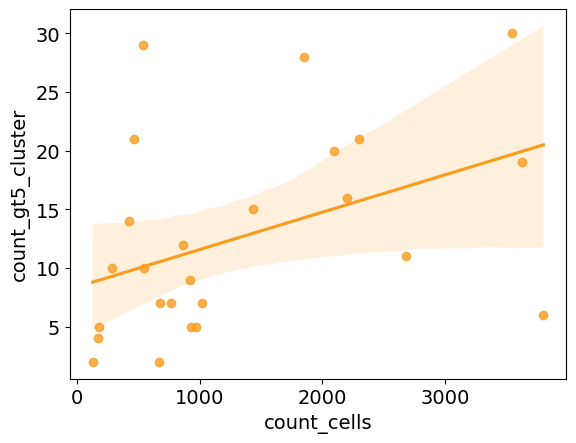

In [19]:
# effect of region size is weak but probably still present...
import seaborn as sns
sns.regplot(th_ccf_metrics.loc[regions_to_plot], x='count_cells', y='count_gt5_cluster', 
            color='#F99D20', label='cluster');

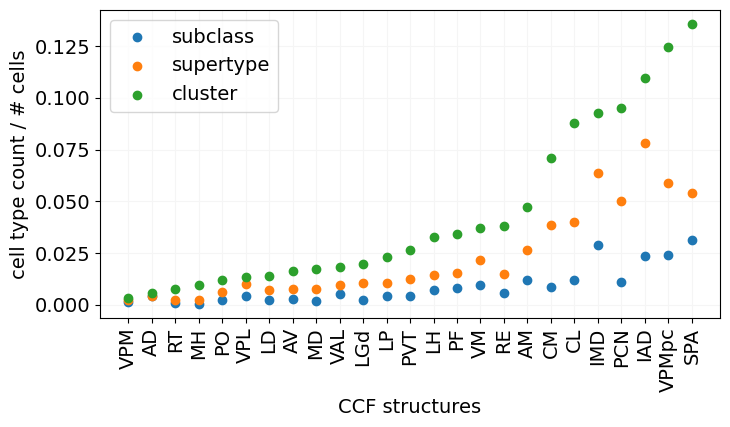

In [20]:
fig = dplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'count_norm2cells', 
                                          ylabel='cell type count / # cells')

## Display CCF structures shaded by metrics

We have also provided a function in `ccf_plots` that allows you to shade the 
CCF structures by a given metric.

We display 'cluster count / # cells' as a usage example.

In [21]:
# need to load the CCF image volumes
ccf_images = abc.get_ccf_labels_image(resampled=True).astype(int)

# pick the same 3 example sections used in the `2_view_thalamus_celltypes_ccf` notebook
sections_3 = [6.4, 7.2, 8.0] 

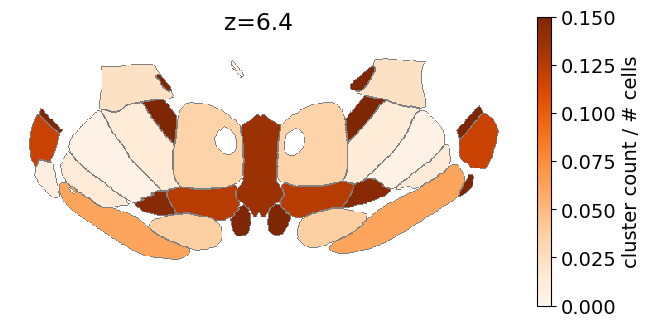

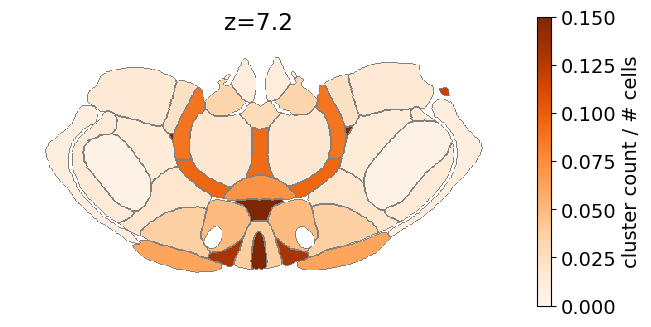

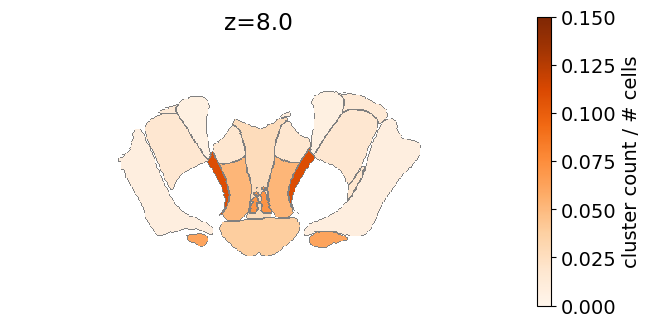

In [22]:
# plot the cell type counts in the CCF structures
figs = cplot.plot_metrics_ccf(ccf_images, 
                              th_ccf_metrics['count_norm2cells_cluster'], 
                              sections_3,
                              vmin=0, vmax=0.15, cmap='Oranges',
                              cb_label='cluster count / # cells')

## Calculate local diversity index

In [23]:
local_isi_df = divmet.calculate_local_diversity_metric(obs_erode, 
                                                       divmet.inverse_simpsons_index, 
                                                       metric_name='isi', 
                                                       n_neighbors=15)
local_isi_df

,local_isi_cluster,local_isi_supertype,local_isi_subclass
cell_label,,,
1019171907102970225,5.232558,4.787234,3.169014
1018093344102600178-2,5.769231,5.769231,2.710843
1018093344102510506-4,2.368421,2.368421,2.227723
1018093344101270649-4,1.300578,1.300578,1.300578
1018093344101260179-5,6.428571,4.787234,3.947368
...,...,...,...
1019171907102620076-1,1.000000,1.000000,1.000000
1020131842101890882,1.744186,1.300578,1.000000
1018093344102470409-5,1.642336,1.642336,1.000000


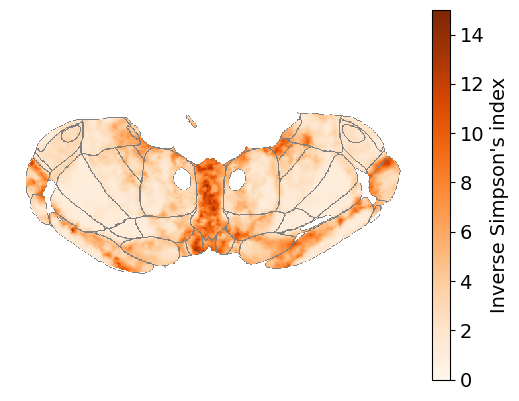

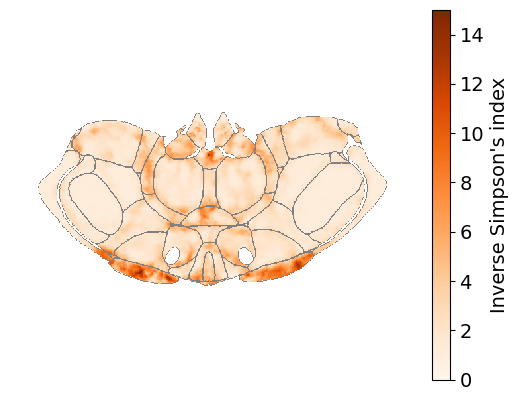

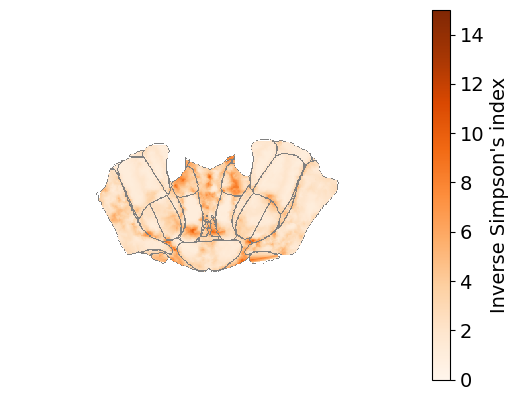

In [24]:
sections_3 = [6.4, 7.2, 8.0]
metric_name = 'local_isi_cluster'
for section in sections_3:
    fig = dplot.plot_local_metric_ccf_section(obs_erode, local_isi_df, ccf_images,
                                              section, metric_name)

## Proportions as stacked bar graphs

### Subclass proportions by region

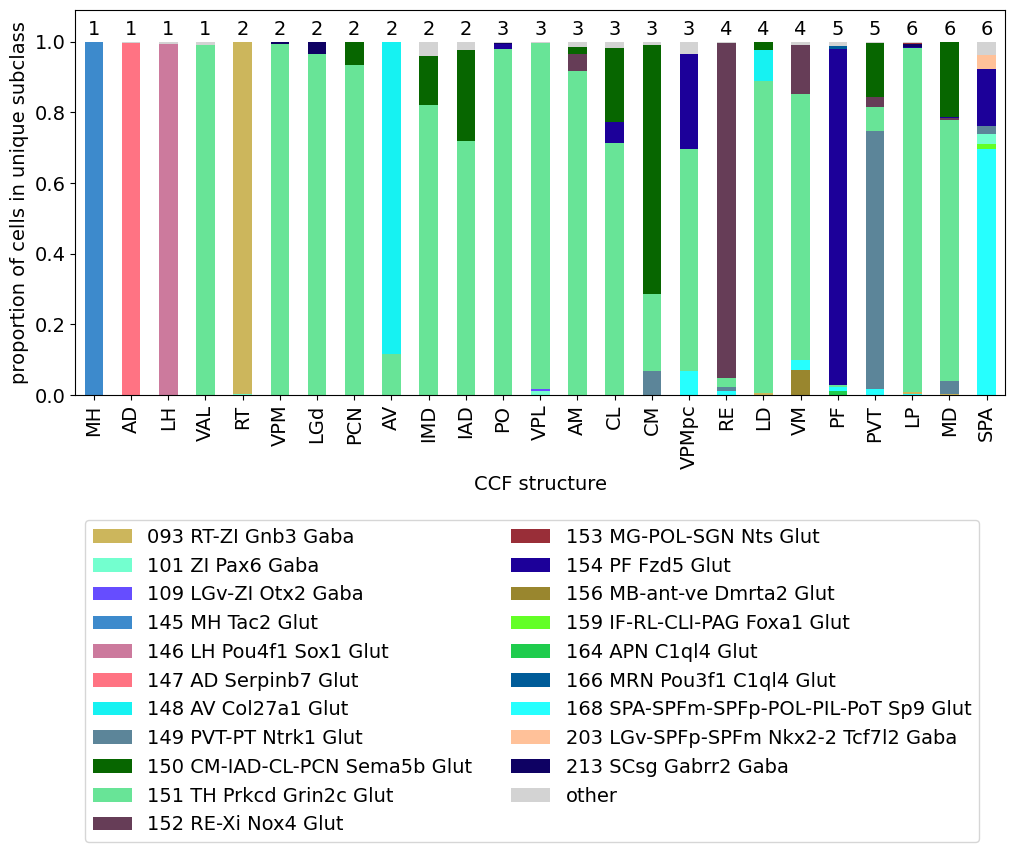

In [25]:
fig = dplot.barplot_stacked_proportions(obs_erode, 'subclass', th_ccf_metrics, legend=True)

### Supertype proportions by region

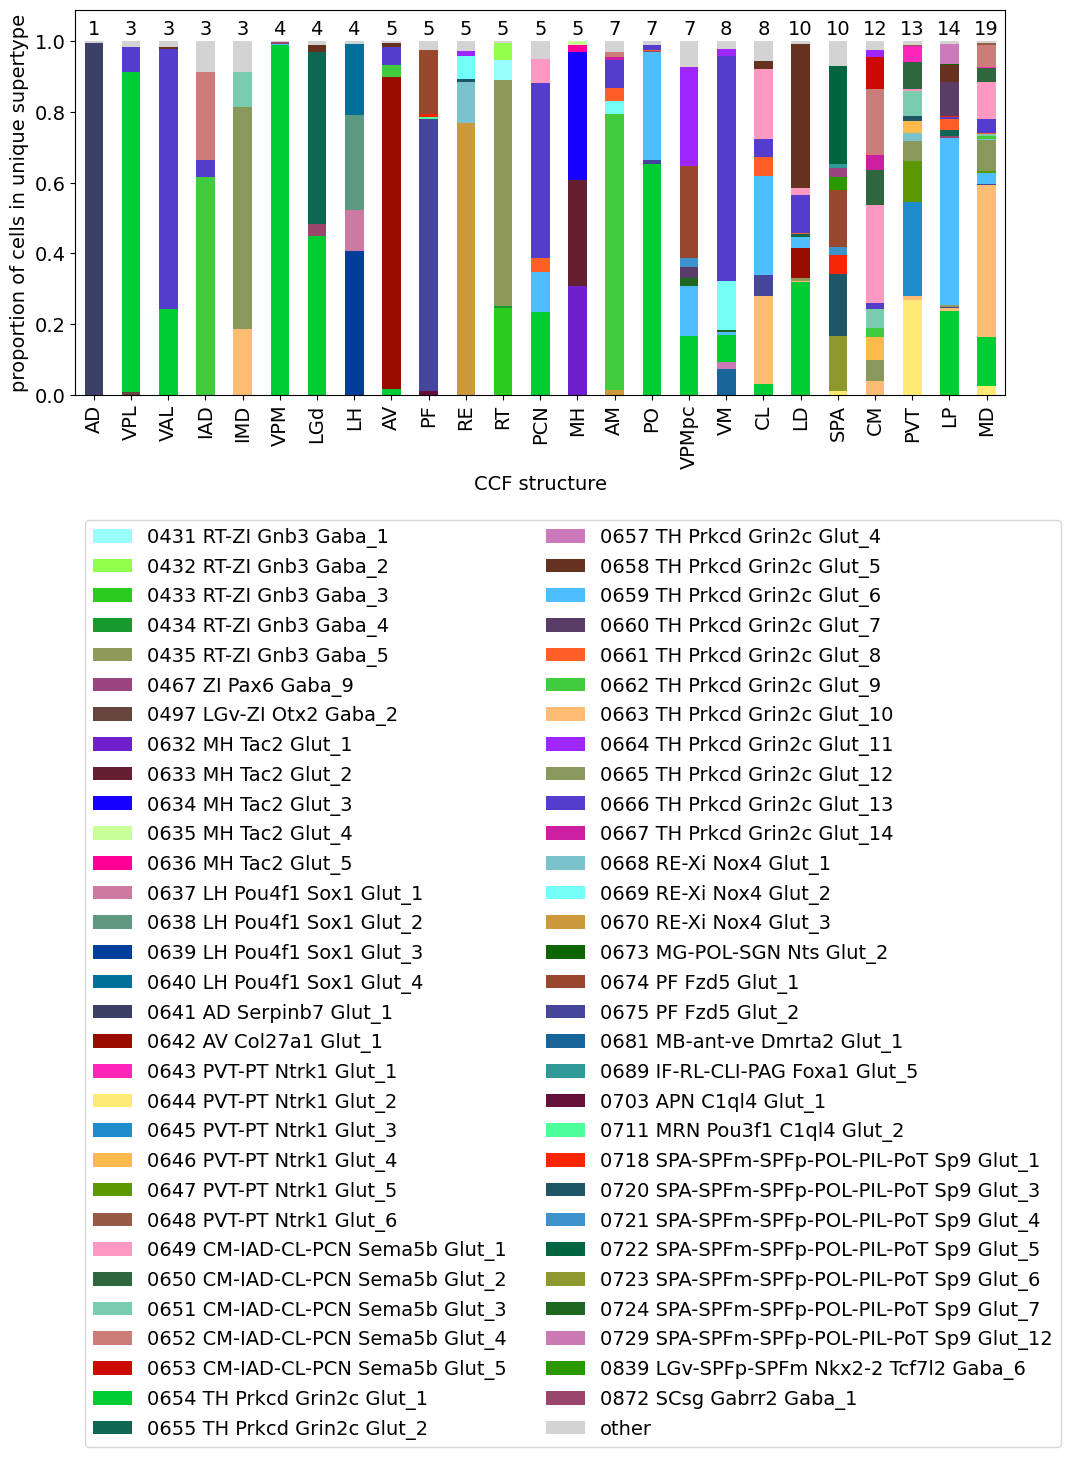

In [26]:
fig = dplot.barplot_stacked_proportions(obs_erode, 'supertype', th_ccf_metrics, legend=True)

### Cluster proportions by region

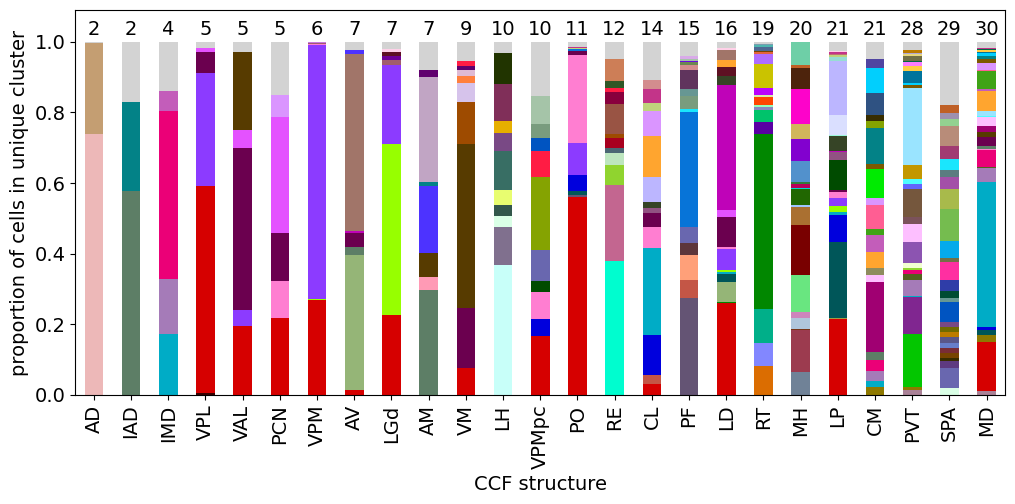

In [27]:
# without legend
fig = dplot.barplot_stacked_proportions(obs_erode, 'cluster', th_ccf_metrics, legend=False)

In [28]:
#  with legend - uncomment to view the very long list of clusters
# fig = dplot.barplot_stacked_proportions(obs_erode, 'cluster', th_ccf_metrics, legend=True)